## set running directory to project source

In [1]:
import os
import numpy as np
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## 4.1 PlanningScene

##### initialize CombinedRobot and GeometryScene

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder

s_builder = SceneBuilder(None)   # create scene builder without detector for virtual scene
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0,0,0), (0,0,0)), None)]
                     , connection_list=[False])
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.show_pose(crob.home_pose)

connection command:
indy0: False
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


##### add geometries

In [3]:
from pkg.geometry.geometry import *

# add environments (fixed=True for non-movable geometries)
wall = gscene.create_safe(GEOTYPE.BOX, "wall", "base_link", (2,2,0.01), (-0.2,0,0), 
                           rpy=(0,np.pi/2,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
floor = gscene.create_safe(GEOTYPE.BOX, "floor", "base_link", (2,2,0.01), (0,0,0), 
                           rpy=np.random.rand(3)*0, color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
goal = gscene.create_safe(GEOTYPE.BOX, "goal", "base_link", (0.1,0.1,0.01), (0.3,-0.4,0.0), 
                          rpy=(0,0,0), color=(0.2,0.2,0.8,1), display=True, fixed=True, collision=True)
 
# add movable (fixed=False for movable geometries)
box1 = gscene.create_safe(GEOTYPE.BOX, "box1", "base_link", (0.05,0.05,0.05), (0.3,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.2,0.2,1), display=True, fixed=False, collision=True)
# add movable (fixed=False for movable geometries)
box2 = gscene.create_safe(GEOTYPE.BOX, "box2", "base_link", (0.05,0.05,0.05), (0.23,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)
# add movable (fixed=False for movable geometries)
box3 = gscene.create_safe(GEOTYPE.BOX, "box3", "base_link", (0.05,0.05,0.05), (0.3,0.33,0.031), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)
# add movable (fixed=False for movable geometries)
box4 = gscene.create_safe(GEOTYPE.BOX, "box4", "base_link", (0.05,0.05,0.05), (0.37,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)
# add movable (fixed=False for movable geometries)
box5 = gscene.create_safe(GEOTYPE.BOX, "box5", "base_link", (0.05,0.05,0.05), (0.3,0.47,0.031), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)

##### create PlanningScene

In [4]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

##### create_binder
- Binders (or Actors) are binding points where objects can be attached (or binded)
- Examples are 
  - PlacePlane: plane for object placement
  - Gripper2Tool: 2-finger gripper tool for grasp objects
  - SweepTool: action point to pass waypoints for sweep task

In [5]:
from pkg.planning.constraint.constraint_actor import PlacePlane, Gripper2Tool, SweepFramer

In [6]:
# create PlacePlane on geometry "floor" and "goal"
# when point is not set, the entire upper surface of the geometry becomes valid binding area.
# when point is set, the specific point becomes the only valid binding point.
pscene.create_binder(bname="floor", gname="floor", _type=PlacePlane, point=None)
pscene.create_binder(bname="goal", gname="goal", _type=PlacePlane, point=(0,0,0.005))

In [7]:
# add collision boundary for gripper base
# - set link_name="indy0_tcp" to attach the geometry to end-effector link
# - it can be labeled as fixed=True, as it is "fixed" on the indy0_tcp link
gripper =  gscene.create_safe(GEOTYPE.BOX, "gripper", link_name="indy0_tcp", 
                                dims=(0.02,0.1,0.1), center=(0,0,0.05), rpy=(0,0,0), 
                                color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True)

# add gripper fingers - By setting parent="gripper", the position of geometry can be set relative to the parent geometry
finger1 =  gscene.create_safe(GEOTYPE.BOX, "finger1", link_name="indy0_tcp",
                              dims=(0.04,0.02,0.1), center=(0,0.04,0.07), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True, parent="gripper")
finger2 =  gscene.create_safe(GEOTYPE.BOX, "finger2", link_name="indy0_tcp", 
                              dims=(0.04,0.02,0.1), center=(0,-0.04,0.07), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True, parent="gripper")

# create Gripper2Tool binder
# Gripper2Tool is a 2-finger gripper, which can rotate along z-direction.
# To align the z-direction with the 2 fingers, rotate by 90 degree along roll axis.
# The gripping point is (0,0,0.11) in local coordinate of "gripper" geometry
pscene.create_binder(bname="grip0", gname="gripper", _type=Gripper2Tool, point=(0,0,0.11), rpy=(-np.pi/2,0,0))

##### create_subject
* Subject describes the tasks in the planning scene.
* There are 2 categories in subject:
  1. Object: The object has grip points and placement points for pick&place task
  2. Task: The task is can be any non-physical task. Check SweepLineTask for example
* The subjects can be composed of multiple action points. Examples are:
  1. Grasp2Point: grasping point for 2-finger gripper. 
  2. PlacePoint: The point to place object.
  3. SweepPoint: A waypoint for SweepLineTask.
  * The above 3 action points inherit DirectePoint, for which the orientation is free along z-axis. 
  * If "point" parameter is not set, the entire upper surface is becomes valid action area.

In [8]:
from pkg.planning.constraint.constraint_subject import Grasp2Point, PlacePoint, SweepFrame
from pkg.planning.constraint.constraint_subject import BoxObject

In [9]:
## create box object with grasping points along positive & negative y-direction and placement point in the bottom face
box_obj_1 = pscene.create_subject(oname="box1", gname="box1", _type=BoxObject)
box_obj_2 = pscene.create_subject(oname="box2", gname="box2", _type=BoxObject)
box_obj_3 = pscene.create_subject(oname="box3", gname="box3", _type=BoxObject)
box_obj_4 = pscene.create_subject(oname="box4", gname="box4", _type=BoxObject)
box_obj_5 = pscene.create_subject(oname="box5", gname="box5", _type=BoxObject)

##### initialize_state
* initialize_state(robot_pose) updates robot pose and gets corresponding binding status of current scene.
* state.node of ('floor', 0) means the first subject (object) is placed on the floor and the second subject (sweep) has passed 0 waypoints

In [10]:
from pkg.utils.code_scraps import *

initial_state = pscene.initialize_state(crob.home_pose)
use_current_place_point_only(pscene, initial_state)
print(initial_state.node)

('floor', 'floor', 'floor', 'floor', 'floor')


## 4.2 MotionPlanner

##### MoveitPlanner
* *get_available_binding_dict()* gets available binding states for each subject in a dictionary
* *sample_leaf_state samples()* target state with given available_binding_dict and target node
* *rebind_all()* updates binding state and returns the resultant state
* The motions tested in this section are:
  - pick: move the object to "gripper"
  - place: move the object to "goal"
  - sweep: 
    1) approach to waypoint 1
    2) sweep to waypoint 2
    3) return to home pose

In [11]:
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType, PlannerConfig

gtimer = GlobalTimer.instance()
gtimer.reset()

In [12]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
gcheck, rcheck = GraspChecker(pscene), ReachChecker(pscene)
mplan = MoveitPlanner(pscene)
mplan.motion_filters=[gcheck, rcheck]

## 4.3 TaskPlanner

##### create PlanningPipeline

In [13]:
from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)
ppline.set_motion_planner(MoveitPlanner(pscene))

In [14]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


##### RRT

In [15]:
from pkg.planning.task.rrt import TaskRRT
ppline.set_task_planner(TaskRRT(pscene))
mplan.motion_filters=[gcheck, rcheck]

- pick & place & sweep (single process)
  - this can fail due to short timeout

In [37]:
gtimer.reset()
succ_list = []
time_list = []
len_list = []
travel_list = []
for _ in range(10):
    ppline.mplan.update_gscene()
    ppline.tplan.prepare()
    gtimer.tic("test")
    ppline.search(initial_state, 
                  goal_nodes=[("goal", "floor", "floor", "floor", "floor")], 
                  verbose=False, display=False, dt_vis=0.01, 
                  timeout_loop=100, max_solution_count=1, 
                  timeout=0.5, timeout_constrained=2, multiprocess=True, add_homing=False)
    elapsed = gtimer.toc("test")
    schedule = ppline.tplan.get_best_schedule(at_home=False)
    succ_list.append(len(schedule)>0)
    if schedule:
        time_list.append(elapsed)
        len_list.append(len(schedule))
        travel_list.append(schedule[-1].traj_tot)

Use 18/36 agents
Goal reached
Goal reached
======================= terminated 4: required answers acquired  (36.9/100.0) ===============================
======================= terminated 13: Stop called from other agent  (36.9/100.0) ===============================
======================= terminated 5: Stop called from other agent  (36.9/100.0) ===============================
======================= terminated 14: Stop called from other agent  (36.9/100.0) ===============================
======================= terminated 2: Stop called from other agent  (37.0/100.0) ===============================
======================= terminated 10: Stop called from other agent  (37.0/100.0) ===============================
======================= terminated 0: Stop called from other agent  (37.1/100.0) ===============================
======================= terminated 15: Stop called from other agent  (37.1/100.0) ===============================
======================= terminated 12: Stop called f

======================= terminated 8: Stop called from other agent  (3.8/100.0) ===============================
======================= terminated 12: Stop called from other agent  (3.8/100.0) ===============================
======================= terminated 6: Stop called from other agent  (3.8/100.0) ===============================
======================= terminated 17: Stop called from other agent  (3.8/100.0) ===============================
======================= terminated 13: Stop called from other agent  (3.9/100.0) ===============================
======================= terminated 1: Stop called from other agent  (3.9/100.0) ===============================
======================= terminated 9: Stop called from other agent  (4.0/100.0) ===============================
======================= terminated 2: Stop called from other agent  (4.0/100.0) ===============================
======================= terminated 14: Stop called from other agent  (4.0/100.0) ====================

======================= terminated 5: max iteration time reached (100.4/100.0 s)  (100.4/100.0) ===============================
======================= terminated 10: max iteration time reached (100.4/100.0 s)  (100.4/100.0) ===============================
======================= terminated 2: max iteration time reached (100.4/100.0 s)  (100.4/100.0) ===============================
======================= terminated 14: max iteration time reached (100.5/100.0 s)  (100.5/100.0) ===============================
[ERROR] Non-joined subprocesses: [6]
========================== FINISHED (100.7 / 100.0 s) ==============================]
Use 18/36 agents
Goal reached
Goal reached
======================= terminated 2: required answers acquired  (83.5/100.0) ===============================
======================= terminated 8: Stop called from other agent  (83.5/100.0) ===============================
======================= terminated 6: Stop called from other agent  (83.5/100.0) ================

======================= terminated 4: Stop called from other agent  (72.3/100.0) ===============================
======================= terminated 0: Stop called from other agent  (72.4/100.0) ===============================
======================= terminated 17: Stop called from other agent  (72.4/100.0) ===============================
======================= terminated 11: Stop called from other agent  (72.4/100.0) ===============================
======================= terminated 15: Stop called from other agent  (72.5/100.0) ===============================
======================= terminated 5: Stop called from other agent  (72.5/100.0) ===============================
======================= terminated 14: Stop called from other agent  (72.6/100.0) ===============================
======================= terminated 12: Stop called from other agent  (72.6/100.0) ===============================
======================= terminated 1: Stop called from other agent  (72.6/100.0) ==========

======================= terminated 3: Stop called from other agent  (93.5/100.0) ===============================
======================= terminated 9: Stop called from other agent  (93.5/100.0) ===============================
======================= terminated 16: Stop called from other agent  (93.5/100.0) ===============================
======================= terminated 7: Stop called from other agent  (93.5/100.0) ===============================
======================= terminated 2: Stop called from other agent  (93.6/100.0) ===============================
[ERROR] Non-joined subprocesses: [0, 15]
========================== FINISHED (93.9 / 100.0 s) ==============================]
Use 18/36 agents
======================= terminated 1: max iteration time reached (100.1/100.0 s)  (100.1/100.0) ===============================
======================= terminated 17: max iteration time reached (100.1/100.0 s)  (100.1/100.0) ===============================
======================= terminated

======================= terminated 14: Stop called from other agent  (87.7/100.0) ===============================
======================= terminated 11: Stop called from other agent  (87.8/100.0) ===============================
======================= terminated 13: Stop called from other agent  (87.8/100.0) ===============================
======================= terminated 6: Stop called from other agent  (87.9/100.0) ===============================
======================= terminated 0: Stop called from other agent  (88.0/100.0) ===============================
======================= terminated 1: Stop called from other agent  (88.0/100.0) ===============================
======================= terminated 4: Stop called from other agent  (88.0/100.0) ===============================
======================= terminated 10: Stop called from other agent  (88.0/100.0) ===============================
======================= terminated 3: Stop called from other agent  (88.0/100.0) ===========

======================= terminated 3: Stop called from other agent  (54.1/100.0) ===============================
======================= terminated 13: Stop called from other agent  (54.1/100.0) ===============================
======================= terminated 7: Stop called from other agent  (54.1/100.0) ===============================
======================= terminated 10: Stop called from other agent  (54.3/100.0) ===============================
======================= terminated 5: Stop called from other agent  (54.3/100.0) ===============================
======================= terminated 11: Stop called from other agent  (54.3/100.0) ===============================
[ERROR] Non-joined subprocesses: [4]
========================== FINISHED (54.4 / 100.0 s) ==============================]
Use 18/36 agents
Goal reached
Goal reached
======================= terminated 6: required answers acquired  (37.7/100.0) ===============================
======================= terminated 9: Stop c

In [26]:
pscene.set_object_state(initial_state)
gscene.show_pose(initial_state.Q)

In [91]:
schedule = ppline.tplan.get_best_schedule(at_home=False)
schedule += ppline.add_return_motion(schedule[-1])
ppline.play_schedule(schedule)

Goal reached
('floor', 'floor', 'floor', 'floor', 'floor')->('floor', 'gripper', 'floor', 'floor', 'floor')
('floor', 'gripper', 'floor', 'floor', 'floor')->('floor', 'floor', 'floor', 'floor', 'floor')
('floor', 'floor', 'floor', 'floor', 'floor')->('floor', 'floor', 'floor', 'gripper', 'floor')
('floor', 'floor', 'floor', 'gripper', 'floor')->('floor', 'floor', 'floor', 'floor', 'floor')
('floor', 'floor', 'floor', 'floor', 'floor')->('gripper', 'floor', 'floor', 'floor', 'floor')
('gripper', 'floor', 'floor', 'floor', 'floor')->('goal', 'floor', 'floor', 'floor', 'floor')
('goal', 'floor', 'floor', 'floor', 'floor')->('goal', 'floor', 'floor', 'floor', 'floor')


## IncrementalSearch

In [26]:
from pkg.planning.incremental_search import *
inc = IncrementalSearch(pscene, gcheck, rcheck)
inc.prepare()
inc.set_motion_planner(mplan)
inc.prepare()
mplan.motion_filters=[]

cresv = CollisionResolver(inc, gcheck)
rresv = ReachResolver(inc, rcheck, mplan)
mresv = MotionResolver(inc, mplan)
inc.resolver_stack = [cresv, rresv, mresv]

In [27]:
gtimer.reset()
succ_list2 = []
time_list2 = []
len_list2 = []
travel_list2 = []
for _ in range(10):
    pscene.set_object_state(initial_state)
    inc.prepare()
    inc.mplan.update_gscene()
    gtimer.tic("test")
    inc.search(initial_state, [("goal", "floor", "floor", "floor", "floor")],  
               max_solution_count=1,
               verbose=False, display=False, dt_vis=0.01, 
               timeout=1.0, timeout_loop=200, 
               multiprocess=True, add_homing=False)
    elapsed = gtimer.toc("test")
    schedule = inc.tplan.get_best_schedule(at_home=False)
    succ_list2.append(len(schedule)>0)
    if schedule:
        time_list2.append(elapsed)
        len_list2.append(len(schedule))
        travel_list2.append(schedule[-1].traj_tot)

Use 18/36 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
======================= terminated 9: required answers acquired  (5.4/200.0) ===============================
======================= terminated 2: Stop called from other agent  (5.4/200.0) ===============================
======================= terminated 6: required answers acquired  (5.4/200.0) ===============================
======================= terminated 13: Stop called from other agent  (5.4/200.0) ===============================
======================= terminated 8: required answers acquired  (5.4/200.0) ===============================
======================= terminated 10: Stop called from other agent  (5.5/200.0) ====================

======================= terminated 11: Stop called from other agent  (8.3/200.0) ===============================
======================= terminated 6: Stop called from other agent  (8.3/200.0) ===============================
======================= terminated 10: Stop called from other agent  (8.3/200.0) ===============================
======================= terminated 14: Stop called from other agent  (8.3/200.0) ===============================
======================= terminated 7: Stop called from other agent  (8.4/200.0) ===============================
======================= terminated 9: Stop called from other agent  (8.4/200.0) ===============================
======================= terminated 8: Stop called from other agent  (8.4/200.0) ===============================
======================= terminated 15: Stop called from other agent  (8.4/200.0) ===============================
======================= terminated 2: Stop called from other agent  (8.6/200.0) ====================

======================= terminated 13: Stop called from other agent  (6.5/200.0) ===============================
======================= terminated 11: Stop called from other agent  (6.5/200.0) ===============================
======================= terminated 5: Stop called from other agent  (6.6/200.0) ===============================
======================= terminated 1: Stop called from other agent  (6.6/200.0) ===============================
======================= terminated 0: Stop called from other agent  (6.7/200.0) ===============================
======================= terminated 2: Stop called from other agent  (6.7/200.0) ===============================
======================= terminated 7: Stop called from other agent  (6.9/200.0) ===============================
======================= terminated 4: Stop called from other agent  (7.0/200.0) ===============================
========================== FINISHED (7.0 / 200.0 s) ==============================]
Use 18/36 agents
[

======================= terminated 13: Stop called from other agent  (12.0/200.0) ===============================
======================= terminated 7: Stop called from other agent  (12.2/200.0) ===============================
[ERROR] Non-joined subprocesses: [7]
========================== FINISHED (12.3 / 200.0 s) ==============================]
Use 18/36 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
======================= terminated 12: required answers acquired  (15.0/200.0) ===============================
======================= terminated 11: required answers acquired  (15.1/200.0) ===============================
======================= terminated 13: required answers acquired  (15.2/200.0) ===============================
======================= terminated 6: Stop called from other 

======================= terminated 8: required answers acquired  (15.0/200.0) ===============================
======================= terminated 16: Stop called from other agent  (15.0/200.0) ===============================
======================= terminated 3: Stop called from other agent  (15.0/200.0) ===============================
======================= terminated 2: Stop called from other agent  (15.1/200.0) ===============================
======================= terminated 1: Stop called from other agent  (15.2/200.0) ===============================
======================= terminated 14: Stop called from other agent  (15.4/200.0) ===============================
======================= terminated 13: Stop called from other agent  (15.5/200.0) ===============================
======================= terminated 12: Stop called from other agent  (15.5/200.0) ===============================
======================= terminated 6: Stop called from other agent  (15.5/200.0) ==============

======================= terminated 10: Stop called from other agent  (6.5/200.0) ===============================
======================= terminated 2: Stop called from other agent  (6.6/200.0) ===============================
======================= terminated 8: Stop called from other agent  (6.7/200.0) ===============================
======================= terminated 14: Stop called from other agent  (6.7/200.0) ===============================
======================= terminated 7: Stop called from other agent  (6.8/200.0) ===============================
======================= terminated 16: Stop called from other agent  (6.8/200.0) ===============================
======================= terminated 3: Stop called from other agent  (6.8/200.0) ===============================
======================= terminated 5: Stop called from other agent  (6.9/200.0) ===============================
======================= terminated 9: Stop called from other agent  (7.0/200.0) =====================

======================= terminated 5: Stop called from other agent  (11.5/200.0) ===============================
======================= terminated 10: Stop called from other agent  (11.6/200.0) ===============================
======================= terminated 15: Stop called from other agent  (11.7/200.0) ===============================
======================= terminated 12: Stop called from other agent  (11.7/200.0) ===============================
========================== FINISHED (11.8 / 200.0 s) ==============================]
Use 18/36 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
======================= terminated 7: required answers acquired  (13.3/200.0) ===============================
===

[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
======================= terminated 9: required answers acquired  (13.2/200.0) ===============================
======================= terminated 7: Stop called from other agent  (13.2/200.0) ===============================
======================= terminated 16: required answers acquired  (13.3/200.0) ===============================
======================= terminated 6: Stop called from other agent  (13.3/200.0) ===============================
======================= terminated 0: Stop called from other agent  (13.4/200.0) ===============================
======================= terminated 14: Stop called from other agent  (13.4/200.0) ===============================
======================= terminated 17: Stop called from other agent  (13.5/200.0) ===============================
======================= terminated 10: Stop called from other agent  (13.5/200.0) ===============================
======================= terminated 13:

In [90]:
schedule = inc.get_best_schedule()
inc.play_schedule(schedule)

IndexError: list index out of range

# rescale

In [51]:
time_list = np.divide(time_list, 1000)
time_list2 = np.divide(time_list2, 1000)

## Plot

In [61]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

Text(0,0.5,'Time[s]')

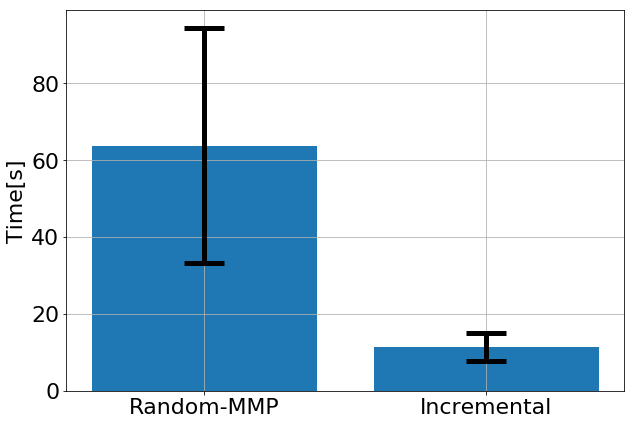

In [72]:
plt.figure(figsize=(10,7))
plt.bar(["Random-MMP", "Incremental"], 
        [np.mean(time_list), np.mean(time_list2)],
        yerr=[np.std(time_list), np.std(time_list2)], 
        error_kw=dict(capsize=20, linewidth=5, markeredgewidth=5)
            )
plt.grid()
plt.ylabel("Time[s]")
np.mean(time_list), np.mean(time_list2)

Text(0,0.5,'Success rate[%]')

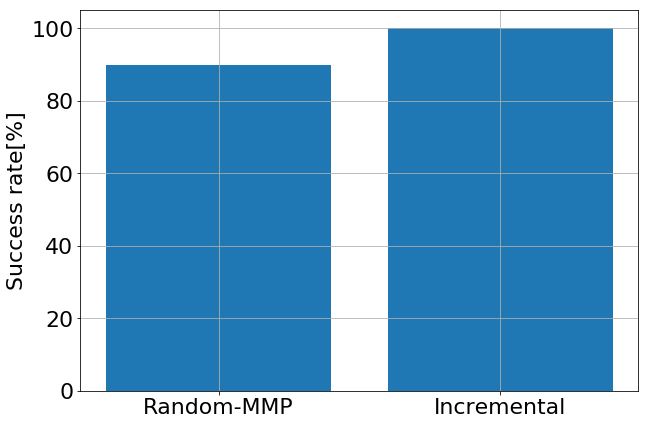

In [73]:
plt.figure(figsize=(10,7))
plt.bar(["Random-MMP", "Incremental"], 
        [np.mean(succ_list)*100, np.mean(succ_list2)*100])
plt.grid()
plt.ylabel("Success rate[%]")
np.mean(succ_list)*100, np.mean(succ_list2)*100

(9.222222222222221, 8.8)

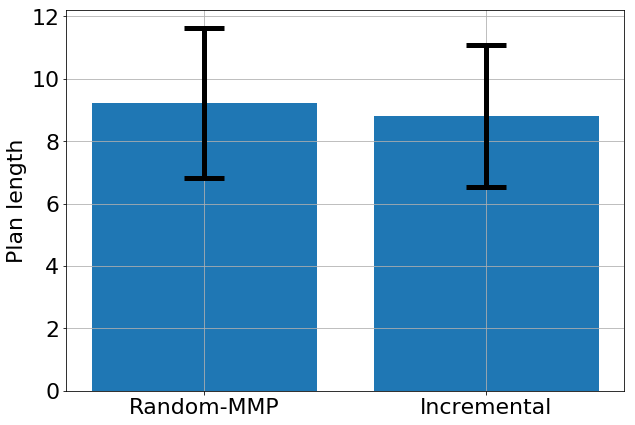

In [84]:
plt.figure(figsize=(10,7))
plt.bar(["Random-MMP", "Incremental"], 
        [np.mean(len_list), np.mean(len_list2)],
        yerr=[np.std(len_list), np.std(len_list2)], 
        error_kw=dict(capsize=20, linewidth=5, markeredgewidth=5)
       )
plt.grid()
plt.ylabel("Plan length")
np.mean(len_list), np.mean(len_list2)

(86.68379749187851, 76.26284842491211)

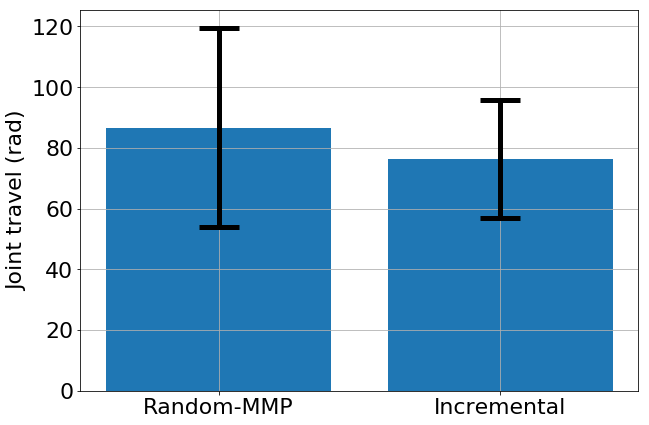

In [89]:
plt.figure(figsize=(10,7))
plt.bar(["Random-MMP", "Incremental"], 
        [np.mean(travel_list), np.mean(travel_list2)],
        yerr=[np.std(travel_list), np.std(travel_list2)], 
        error_kw=dict(capsize=20, linewidth=5, markeredgewidth=5)
       )
plt.grid()
plt.ylabel("Joint travel (rad)")
np.mean(travel_list), np.mean(travel_list2)